# Machine Learning algorithms

## Introduction

In this notebook we will study 2 different Machine Learning algorithms **Perceptron Learning Algorithm (PLA)** and its variant **ADaptative LInear NEuron (ADALINE)**. We will do that through doing a set of experiments for each algorithm and analyzing its results to finally discuss the main features of each algorithm.

### Learning from data
<img src="images/lfd.png" alt="drawing" width="400"/>

- Write and Introduction of ML according to the Book


- Write a paragraph talking about the different ML algorithms


- Describe the PLA algorithm


- Describe the Adaline algorithm


- Compare both algorithms


- Explain the experiment

In [83]:
"""
Libraries needed to implement and visualize the PLA algorithm and its variant 
Adaline.
"""
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import imageio
import sys
import os
from IPython.display import HTML

# Images path
IMAGE_PATH = 'images/'

# setting up the figure size
rcParams["figure.figsize"] = 5, 5
rcParams.update({'figure.max_open_warning': 0})

In [84]:
class Perceptron:
    """
    PLA, Perceptron Learning Algorithm and Adaline, Adaptive Linear Neuron.

    Parameters
    ----------
        N : Integer
            Number of linearly separable points to generate.
        datarseed : Integer
            Seed used to initialize the datas random generator.
            Default: 1324
        rmispts : Boolean
            If True the misclassified points are selected randomly.
            Default: False
        misptsrseed : Integer
            Seed used to initialize the misclasifications random generator.
            Default: 1324
        dimension : Integer
            Dimension in which the points are generated.
            Default: 2
    Attributes
    ----------
        w : array
            Weights vector.
        X : array, shape = [nsamples, nfeatures]
            Training vectors, where 'nasamples' is the number of
            samples and 'nfeatures' is the number of features.
        V : array
            Line in 2d or n-plane in n-dimensions that separates the points.
        dim : array
            Dimension in which the algorithm works.
    """

    def __init__(
        self, N, datarseed=1324, rmispts=False, misptsrseed=1234, dimension=2
    ):

        self.dim = dimension
        self.rgendata = np.random.RandomState(datarseed)
        self.rgenmispts = np.random.RandomState(misptsrseed)
        self.rmispts = rmispts

        # Random linearly separated data,
        var = [self.rgendata.uniform(-1, 1) for i in range(self.dim * 2)]
        for i in range(self.dim + 1):
            if i == 0:
                self.V = np.array(
                    var[i + 2] * var[i + 1] - var[i] * var[i + 3])
            elif i % 2 == 0:
                self.V = np.append(self.V, var[i] - var[i - 1])
            else:
                self.V = np.append(self.V, var[i])

        self.X = self.generate_points(N)

    def generate_points(self, N):
        """
        Generate linearly separable data points method.

        Parameters
        -----------
        N : Integer
            Number of data points to generate.

        Returns
        --------
        X : array, shape = [nsamples, nfeatures]
            Training vectors, where 'nasamples' is the number of
            samples and 'nfeatures' is the number of features.

        """
        X = []
        for i in range(N):
            xn = [self.rgendata.uniform(-1, 1) for i in range(self.dim)]
            x = np.append([1], xn)
            s = int(np.sign(self.V.T.dot(x)))
            X.append((x, s))
        return X

    def plot(self, mispts=None, vec=None, save=False, imgname='tmp'):
        """
        2D data plot method.

        Parameters
        -----------
        mispts : array
            Set of misclassified data points.
            Default: None
        vec : array
            Weights vector that describes the hypotesis.
            Default: None
        save : Boolean
            If the value is True the plots are saved to disk.
            Default: False
        imgname : String
            Name used to save the plot to disk.
            Default: 'tmp'

        """
        fig = plt.figure(figsize=(5,5))
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        V = self.V

        a, b = -V[1] / V[2], -V[0] / V[2]
        l = np.linspace(-1, 1)

        plt.plot(l, a * l + b, 'k-')
        cols = {1: 'r', -1: 'b'}

        if mispts == None:
            for x, s in self.X:
                plt.plot(x[1], x[2], cols[s] + 'o')

        if mispts:
            for x, s in mispts:
                plt.plot(x[1], x[2], cols[s] + '.')

        if vec != None:
            aa, bb = -vec[1] / vec[2], -vec[0] / vec[2]
            plt.plot(l, aa * l + bb, 'g-', lw=2)

        if save:
            if not mispts:
                plt.title('N = %s' % (str(len(self.X))))
                plt.xlabel('x1')
                plt.ylabel('x2')
            else:
                plt.title(
                    'N = %s with %s test points' %
                    (str(len(self.X)), str(len(mispts)))
                )
                plt.xlabel('x1')
                plt.ylabel('x2')
            plt.savefig(
                IMAGE_PATH + imgname, dpi=75, bbox_inches='tight'
            )
            plt.close()

    def classification_error(self, vec, pts=None):
        """
        Error classification method.

        Parameters
        -----------
        vec : array
            Weights vector used to classify a point.
        pts : array
            Data points to evaluate:
            Default: self.X

        Returns
        --------
        error : float
            Fraction of misclassified points.
        mispts: array
            Set of misclassified points.

        """
        # Error defined as fraction of misclassified points
        if not pts:
            pts = self.X
        M = len(pts)
        n_mispts = 0
        mispts = []
        for x, s in pts:
            if int(np.sign(vec.T.dot(x))) != s:
                n_mispts += 1
                mispts.append((x, s))
        error = n_mispts / float(M)
        return error, mispts

    def choose_miscl_point(self, vec):
        """
        Choose a misclassified point method.

        Parameters
        -----------
        vec : array
            Weights vector used to classify a point.

        Returns
        --------
        mispts[i] : array
            Selected misclassified data point.

        """
        # Choose a random point among the misclassified
        pts = self.X
        mispts = []
        for x, s in pts:
            if int(np.sign(vec.T.dot(x))) != s:
                if not self.rmispts:
                    return (x, s)
                mispts.append((x, s))
        return mispts[self.rgenmispts.randint(0, len(mispts))]

    def pla(self, save=False, suffix=''):
        """
        Perceptron learning algorithm method.

        Parameters
        -----------
        save : Boolean
            If value is True Save the sequence of plots in which the algorithm 
            go through.
        suffix : String
            suffix to add to the name used to save the sequence of plots to disk.

        Returns
        --------
        it : Integer
            Number of iterations the algorithm took to converge.

        """

        # Initialize the weights to zeros
        w = np.zeros(self.dim + 1)
        X, N = self.X, len(self.X)

        it = 0
        # Iterate until all points are correctly classified
        while self.classification_error(w)[0] != 0:
            it += 1
            # Pick random misclassified point
            x, s = self.choose_miscl_point(w)
            # Update weights
            w += s * x
            if save:
                self.plot(vec=w.tolist())
                plt.title('N = %s, Iteration %s\n' % (str(N), str(it)))
                plt.xlabel('x1')
                plt.ylabel('x2')
                plt.savefig(
                    IMAGE_PATH + suffix + 'p_N%s_it%s' % (str(N), str(it)),
                    dpi=75, bbox_inches='tight'
                )
                plt.close()
        self.w = w
        return it

    def adaline(self, save=False, suffix='', lrate=1, limit=10):
        """
        Adaptive linear neuron algorithm method.

        Parameters
        -----------
        save : Boolean
            If value is True Save the sequence of plots in which the algorithm 
            go through.
        suffix : String
            suffix to add to the name used to save the sequence of plots to disk.
        lrate : float
            Learning rate factor.
        limit : Integer
            Maximum number of updates the algorithm does.

        Returns
        --------
        self : object

        """
        # Initialize the weigths to zeros
        w = np.zeros(self.dim + 1)
        X, N = self.X, len(self.X)

        it = 0
        # Iterate until all points are correctly classified
        while it < limit and self.classification_error(w)[0] != 0:
            it += 1
            # Pick random misclassified point
            x, s = self.choose_miscl_point(w)
            y = w.T.dot(x)
            # Update weights
            w += lrate * (s - y) * x
            if save:
                self.plot(vec=w.tolist())
                plt.title('N = %s, Iteration %s\n' % (str(N), str(it)))
                plt.xlabel('x1')
                plt.ylabel('x2')
                plt.savefig(
                    IMAGE_PATH + suffix + 'p_N%s_it%s' % (str(N), str(it)),
                    dpi=75, bbox_inches='tight'
                )
                plt.close()
        self.w = w
        return it

    def check_error(self, M, vec):
        """
        Test data error check method.

        Parameters
        -----------
        N : Integer
            Number of data points to generate.
        vec : array
            Weights vector, generated by running the algorithm with a training
            set, used to classify the data points.

        Returns
        --------
        error : float
            Fraction of misclassified points.
        miscpoints: array
            Set of misclassified points.
        check_pts: array
            The generated data points.

        """
        check_pts = self.generate_points(M)
        error, miscpoints = self.classification_error(vec, pts=check_pts)
        return error, miscpoints, check_pts

## Visualize

In [85]:
def get_images(suffix):
    """
    Get the list of images associated to a suffix.

    Parameters
    -----------
    suffix : String
        Suffix of set of requested images.

    Returns
    --------
    sortpngs : array
        Set of images (plots) names.

    """
    basedir = os.getcwd()
    os.chdir(basedir)
    pngs = [pl for pl in os.listdir(IMAGE_PATH) if pl.endswith(
        'png') and pl.startswith(suffix)]
    sortpngs = sorted(pngs, key=lambda a: int(a.split('it')[1][:-4]))
    return sortpngs

In [86]:
def show_animation(image1, image2):
    """
    Show images or animations method.

    Parameters
    -----------
    image1 : String
        image url.
    image2 : String
        image url.

    Returns
    --------
    htmlcode : HTML

    """
    header = "<html><head><style>*{box-sizing:border-box;}.column{float:left;width:50%;padding:2px;}/*Clearfix(clearfloats)*/.row::after{content:"";clear:both;display:table;}</style></head><body>"
    footer = "</body></html>"
    return HTML(
        header +
        '''
        <div class="row">
            <div class="column">
            <img style="display: block;margin-left: auto;margin-right: auto;width: 65%;" src="''' + IMAGE_PATH + image1 + '''">
            </div>
            <div class="column">
            <img style="display: block;margin-left: auto;margin-right: auto;width: 65%;" src="''' + IMAGE_PATH + image2 + '''">
            </div>
        </div>
        '''
        + footer
    )

In [87]:
def create_animation(filenames, duration=0.50, name='tmp'):
    """
    Create gif animation method. 

    Parameters
    -----------
    filenames : array
        Set of the images names to create the animation.
    duration : float
        Duration of one image in the animation.
    name : String
        Name used to save the animation to disk.

    Returns
    --------
    gifname : String
        Name of the animation file.

    """
    images = []
    for filename in filenames:
        images.append(imageio.imread(IMAGE_PATH + filename))
    gifname = name + ".gif"
    output_file = IMAGE_PATH + '%s' % gifname
    imageio.mimsave(output_file, images, duration=duration)
    return gifname

## PLA, (Problem 1.4  Learning from data book)

In this Experiment, we use an artificial data set to study the perceptron learning algorithm . We are going to explore the algorithm further with data sets of different sizes and dimensions.

- We are first going to generate a linearly separable data set of size $n=20$ points. To generate the data set randomly we will use a radom seed `1995` so we can run it and get the same random result each time we execute it. It is important to notice that the data set generator is already included in the Percpetron class created above.

In [88]:
p_b = Perceptron(20,datarseed=1995)

- We are now going to run the perceptron learning algorithm on the data set above. Since the PLA is an iterative algorithm the main idea is to report the number of updates that the it takes before converging and observe how it performs with respect to the data set.

In [89]:
iterations = p_b.pla(save=True, suffix='pb_')
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 11


- To cleary show what is going on with the algorithm execution we plot the examples $\{ (X_n, Y_n) \}$ , the target function $f$ (**black**), and the final hypothesis $g$ (**green**) in the same figure.

In [90]:
images = get_images('pb_')
animation = create_animation(images,0.50,name='animation_pb_1995')
show_animation(animation, images[-1])

In the first plot we can observe the behaviour of the PLA which passes through **11 iterations** before find an hypothesis which classifies the data correctly. In the second plot we may notice that although $g$ is very close to $f$ and it completely separtes the data set, they are not quite identical.

- We repeat everything we've done above with another randomly, random seed `1996`, generated data set of size $n=20,$ to compare the results.

In [91]:
p_c = Perceptron(20,datarseed=1996)

In [92]:
iterations = p_c.pla(save=True, suffix='pc_')
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 22


In [93]:
images = get_images('pc_')
animation = create_animation(images,0.50,name='animation_pc_1996')
show_animation(animation, images[-1])

In the first plot we can observe the behaviour of the PLA which passes through **22 iterations** before find an hypothesis which classifies the data correctly. In the second plot we may notice that although $g$ is very close to $f$ and it completely  separtes the data set , they are not quite identical. Compared with the previous results this time the PLA took more iterations to converge. We can observe that the PLA can take more or less iterations to converge depending on the data set and not in $f$. 

- In order to analyse the behaviour of the PLA with respect to the data set size we repeat everything we've done in the first part of this experiment, with a nother randomly generated data set of size $n=100$.

In [94]:
p_d = Perceptron(100,datarseed=7878)

In [95]:
iterations = p_d.pla(save=True, suffix='pd_')
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 75


In [96]:
images = get_images('pd_')
animation = create_animation(images,0.50,name='animation_pd_7878')
show_animation(animation, images[-1])

In the first plot we can observe the behaviour of the PLA which passes through **75 iterations** before converge. In the second plot we may notice that $g$ if pretty close to $f$ and it completely separtes the data set. Compared with the two previous results this time the PLA took more iterations than both. Also we can notice that this time $g$ is more similiar to $f$. 

- In order to analyse the behaviour of the PLA with respect to the data set size we again repeat everything we've done in the first part of this experiment, with another randomly generated data set of size $n=1000$.

In [97]:
p_e = Perceptron(1000,datarseed=2000)
p_e.plot(save=True, imgname='pe_sample_2000')

In [98]:
iterations = p_e.pla()
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 432


In [99]:
p_e.plot(vec=p_e.w.tolist(), save=True, imgname='animation_pe_sample_2000')
show_animation('pe_sample_2000.png', 'animation_pe_sample_2000.png')

This time the animation of the PLA algorithm is not shown due to the number of iterations it takes, **432 iterations**. However the first plot shows $f$ and the second one shows $g$ and $f$ together which are nearly indistinguishable. Compared to the previos results we observe that the number of iterations grows when the data set is bigger, but also that $g$ is closer to $f$ since the possibilites to separate the data are fewer.

- We will now try to observe the performance of the PLA modifying the algorithm such that it takes $x_n  \in  \mathbb{R}^{10} $ instead of $\mathbb{R}^2$ . A linearly separable data set of size $n=1000$ will be generated and we will let the PLA run until converge to count the number of iterations it takes to converge. It is important to mention that it is possible to specify the number of dimensions in which the algorithm works within the Perceptron class created above.

In [100]:
p_f = Perceptron(1000,datarseed=2003,dimension=10)
iterations = p_f.pla()
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 4569


The PLA took **4569 iterations** way higher than the previous results with $x \in \mathbb{R}^2$. So we can say that the increase on the dimensios has an significant impact in the PLA performance.

- Repeat the algorithm on the same data set used above for 100 experiments. In the iterations of each experiment, pick $x(t)$ **randomly** instead of deterministically. Plot a histogram for the number of updates that the algorithm takes to converge.

`Note:` Please consider that running this code below could take long time. If you want to run it please change the `run` boolean variable to `True`.

In [101]:
import random
aiter = []
run = False # change to run 100 experiments
g = random.Random()
g.seed(8435)
rs = g.sample(range(1000, 9999), 100)
if run:
    for i in range(100):
        p_g = Perceptron(1000,datarseed=2003, rmispts=True, misptsrseed=rs[i], dimension=10)
        iterations = p_g.pla()
        aiter.append(iterations)
        print("Number of iterations: %d, random seed %d" % (iterations,rs[i]))

 |**Iterations**|**Random seed**| |**Iterations**|**Random seed**| |**Iterations**|**Random seed**| |**Iterations**|**Random seed**| |**Iterations**|**Random seed**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
**1.**|3207|5185|**21.**|2423|6375|**41.**|3391|6652|**61.**|3215|3084|**81.**|3407|9231
**2.**|3711|1550|**22.**|3399|3469|**42.**|2673|8899|**62.**|2969|1391|**82.**|2701|9009
**3.**|3717|7200|**23.**|2495|1138|**43.**|3511|1820|**63.**|3245|6176|**83.**|2895|3670
**4.**|3623|8980|**24.**|3021|2746|**44.**|2279|7739|**64.**|2671|6455|**84.**|3329|2762
**5.**|1971|6864|**25.**|3397|7554|**45.**|2435|2125|**65.**|2693|1755|**85.**|3409|3730
**6.**|2960|1665|**26.**|3037|1620|**46.**|3503|7197|**66.**|2969|2935|**86.**|2535|4068
**7.**|2437|4429|**27.**|2971|1574|**47.**|3127|1052|**67.**|3517|1260|**87.**|2311|5362
**8.**|3907|6619|**28.**|3477|2468|**48.**|2363|1601|**68.**|2881|5693|**88.**|2251|5258
**9.**|1959|9700|**29.**|2737|7188|**49.**|2681|5742|**69.**|2885|7089|**89.**|2827|1671
**10.**|2487|4882|**30.**|2627|4789|**50.**|3205|4969|**70.**|3231|8424|**90.**|3417|4125
**11.**|2367|4599|**31.**|3719|3910|**51.**|2843|1141|**71.**|3617|3684|**91.**|2399|6289
**12.**|2501|9305|**32.**|3283|9501|**52.**|3107|8812|**72.**|2721|1355|**92.**|2669|5539
**13.**|2913|9192|**33.**|2477|2956|**53.**|2851|8673|**73.**|2795|4975|**93.**|2399|9730
**14.**|1999|9419|**34.**|2521|6595|**54.**|2669|3597|**74.**|2245|2371|**94.**|2283|1106
**15.**|3651|9428|**35.**|1805|1196|**55.**|2859|2044|**75.**|2877|1182|**95.**|2857|7987
**16.**|2653|8028|**36.**|1441|1007|**56.**|3645|7939|**76.**|3617|5816|**96.**|2177|1061
**17.**|3263|5212|**37.**|3073|3354|**57.**|3011|8749|**77.**|3023|7602|**97.**|3005|9517
**18.**|3313|9357|**38.**|2987|4439|**58.**|2647|9926|**78.**|3241|3753|**98.**|3329|7092
**19.**|3137|1918|**39.**|2459|6847|**59.**|3245|9533|**79.**|2591|4191|**99.**|2993|1416
**20.**|2885|3109|**40.**|3186|6934|**60.**|2783|1448|**80.**|2781|4462|**100.**|2523|8021

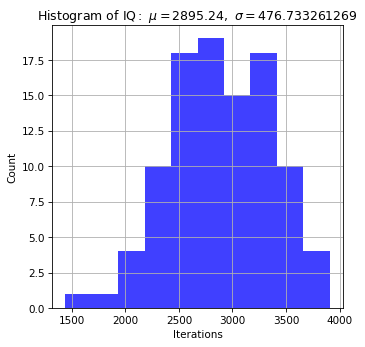

In [102]:
x = np.array(aiter) if run else \
    np.array([3207,3711,3717,3623,1971,2960,2437,3907,1959,2487,
              2367,2501,2913,1999,3651,2653,3263,3313,3137,2885,
              2423,3399,2495,3021,3397,3037,2971,3477,2737,2627,
              3719,3283,2477,2521,1805,1441,3073,2987,2459,3186,
              3391,2673,3511,2279,2435,3503,3127,2363,2681,3205,
              2843,3107,2851,2669,2859,3645,3011,2647,3245,2783,
              3215,2969,3245,2671,2693,2969,3517,2881,2885,3231,
              3617,2721,2795,2245,2877,3617,3023,3241,2591,2781,
              3407,2701,2895,3329,3409,2535,2311,2251,2827,3417,
              2399,2669,2399,2283,2857,2177,3005,3329,2993,2523])

plt.gcf().clear()

# the histogram of the data
n, bins, patches = plt.hist(x, 10, facecolor='blue', alpha=0.75)
plt.xlabel('Iterations')
plt.ylabel('Count')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=' + str(x.mean()) + ',\ \sigma='+ str(x.std()) +'$')
plt.grid(True)

plt.show()

In summary we have executed 100 time the a data set with $n=1000$ where $ x_n  \in  \mathbb{R}^{10} $ using different random seeds to select randomly the miscalssifed point. The results give us a mean of $\mu = 2895.24$ and $\sigma = 476.73$ which compared with previous experiment, in where we chose the misclassified point deterministically, needs in average, less iterations to converge. with a minimum of **1441** and maximum of **3907** iterations.

### Expriment conclusions

The main objectives of this experimet was to understand how the perceptron algorithm works and to observe how the amount of data and the data space affect its performance. So we can conclude that the more separable data we have the closer the hypothesis $g$ 
will be with respecto to $f$. However we could observe that if we choose deterministically the misclassified points  the number of iterations will increase. Another point to make is that, as we observed in the last two sub experiments, the dimension space of the data has a signficant impact on the number of iterations to classify the data, for instance with $x \in \mathbb{R}^2$ we needed 432 iterations while with $x \in \mathbb{R}^{10} $ the algorithm needed 4569 iterations, which is aproximetally 11 times more.

Also we observed that instead of determinstically, we can choose the misclassified point randomly in the PLA, which performed better in an average of 100 trials with different random seeds.

## ADALINE, Problem 1.5

In this second implementation we are going to experiment with a varition of the PLA called ADALINE, which stands for ADaptative LInear NEuron. The main idea of this set of experiments is to train the algorithm varying the value of $\eta$ which is the learning rate.

- We will first Generate a **training data set** of size 100 similar to that used in Exercise 1.4. Then we will generate a **test data set** of size 10,000 from the same process. To get $g$, we will run the ADALINE with $\eta = 100$ on the training data set, until a maximum of 1,000 updates has been reached. We are going to plot the training data set, the target function $f$, and the final hypothesis $g$ and we will also report the error on the test set.

In [103]:
pada_a = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)

iterations = pada_a.adaline(lrate=4, limit=1000)
print("Number of iteratios: %f" % (iterations))

Number of iteratios: 1000.000000


Using $\eta = 100$ was not possible in this experiment since at certain point it started to generates too small values which produced Python to recognized it as a non-finite quantity (NaN). So we instead used the maximun value, $\eta =4$ to avoid that scaneario. In part we had that issue because we are doing 1000 iterations so that means if we use a bigger learning rate we should nee less iterations to converge.

In [104]:
error, miscpoints, x = pada_a.check_error(10000,pada_a.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_a.plot(vec=pada_a.w.tolist(), save=True, imgname='pada_4_10000')
plt.gcf().clear()
pada_a.plot(mispts=miscpoints, save=True, imgname='pada_4_miscpoints')
show_animation('pada_4_10000.png','pada_4_miscpoints.png')

fraction of misclassified points: 0.302700


As a result we can see the two graphs above and observe that $g$ is quite far from $f$ which causes a **fraction of misclassified points = 0.302700** over the 10000 test points we used to test. The result is clearly what we expected since the $g$ is no quite near $f$.

- We will Use the same data set used in the previous sub experiment and redo everything with $\eta = 1$

In [105]:
pada_b = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)

iterations = pada_b.adaline(lrate=1, limit=1000)
print("Number of iteratios: %f" % (iterations))

Number of iteratios: 48.000000


In [106]:
error, miscpoints, x = pada_b.check_error(10000,pada_b.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_b.plot(vec=pada_b.w.tolist(), save=True, imgname='pada_1_10000')
plt.gcf().clear()
pada_b.plot(mispts=miscpoints, save=True, imgname='pada_1_miscpoints')
show_animation('pada_1_10000.png','pada_1_miscpoints.png')

fraction of misclassified points: 0.007400


Training the algorithm with $\eta = 1$ we just needed 48 iterations to separate the data. Testing the the 10000 points data set we got **fraction of misclassified points = 0.0074** which is way better than the previous test. As we can see in the graphs above this time $g$ is closer to $f$ and thus we have better results. In the graph to the right we can observe the missclassified points, 74 in total.

- We will now use the same data set used in the previous sub experiment and redo everything with $\eta = 0.01$

In [107]:
pada_c = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)
iterations = pada_c.adaline(lrate=0.01, limit=1000)

print("Number of iteratios: %f" % (iterations))

Number of iteratios: 603.000000


In [108]:
error, miscpoints, x = pada_c.check_error(10000,pada_c.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_c.plot(vec=pada_c.w.tolist(), save=True, imgname='pada_001_10000')
plt.gcf().clear()
pada_c.plot(mispts=miscpoints, save=True, imgname='pada_001_miscpoints')
show_animation('pada_001_10000.png','pada_001_miscpoints.png')

fraction of misclassified points: 0.003800


Training the algorithm with $\eta = 0.01$ we needed 603 iterations to separate the data which is more than the previous test. However this time we have a better fit $g$ function, almost the same as $f$. Testing the the 10000 points data set we got **fraction of misclassified points = 0.0038** which is way better than the previous test. So at this point we observe that the lower the value of $\eta$ the better results we got but also the more iterations it takes to converge.

- We will now use the same data set used in the previous sub experiment and redo everything with $\eta = 0.0001$

In [109]:
pada_d = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)
iterations = pada_d.adaline(lrate=0.0001, limit=1000)

print("Number of iteratios: %f" % (iterations))

Number of iteratios: 205.000000


In [110]:
error, miscpoints, x = pada_d.check_error(10000,pada_d.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_d.plot(vec=pada_d.w.tolist(), save=True, imgname='pada_00001_10000')
plt.gcf().clear()
pada_d.plot(mispts=miscpoints, save=True, imgname='pada_00001_miscpoints')
show_animation('pada_00001_10000.png','pada_00001_miscpoints.png')

fraction of misclassified points: 0.007500


Training the algorithm with $\eta = 0.0001$ we needed 205 iterations to separate the data which. We can observe that the higuer or lower $\eta$ is the less iterations the algorithm will take to converge. We can see in the first graph that again $g$ is a little deviated from $f$ with **fraction of misclassified points = 0.0075**. We got similar results with $\eta = 1$.

### Expriment conclusions

Analysing the experiments we just have done, we can observe that we obtained better results with a value of $\eta$ that is not in the extremes but in the middle. So we can say that if we need to find a balance in the learning rate because it can push too much or too low to converge.

We also can observe that the greater or lower $\eta$ is the less iterations the algorithm will need to converge. And if $\eta$ is moderate it will converge slower. We can observe that since the number of iterations for $\eta=1$, $\eta=0.01$ and $\eta=0.0001$ converge **48**, **603** and **205** iterations respectivelly. So it is possible to adjust those parameters in order to try to get better results, but we noticed that for classification purposes more iterations is better than a lower or higher learning rate $\eta$.

## Overal conclusion